In [1]:
import onnx
import cv2
import numpy as np
import caffe2
import caffe2.python.onnx.backend as backend

This runs in a standard anaconda environment, which was created by the following commands

`conda create -n onnx python=3 anaconda`

`source activate onnx`

`conda install -c caffe2 caffe2`

`pip install git+git://github.com/onnx/onnx.git@master`

### load the fixed batchnorm onnx file

In [2]:
PATH = "data/project/"

In [3]:
model = onnx.load("sleeves_fixed_batchnorm.proto")


In [4]:
onnx.checker.check_model(model)

In [5]:
onnx.helper.printable_graph(model.graph)


'graph torch-jit-export (\n  %1[FLOAT, 1x3x224x224]\n) initializers (\n  %2[FLOAT, 64x3x7x7]\n  %3[FLOAT, 64]\n  %4[FLOAT, 64]\n  %5[FLOAT, 64]\n  %6[FLOAT, 64]\n  %7[FLOAT, 64x64x3x3]\n  %8[FLOAT, 64]\n  %9[FLOAT, 64]\n  %10[FLOAT, 64]\n  %11[FLOAT, 64]\n  %12[FLOAT, 64x64x3x3]\n  %13[FLOAT, 64]\n  %14[FLOAT, 64]\n  %15[FLOAT, 64]\n  %16[FLOAT, 64]\n  %17[FLOAT, 64x64x3x3]\n  %18[FLOAT, 64]\n  %19[FLOAT, 64]\n  %20[FLOAT, 64]\n  %21[FLOAT, 64]\n  %22[FLOAT, 64x64x3x3]\n  %23[FLOAT, 64]\n  %24[FLOAT, 64]\n  %25[FLOAT, 64]\n  %26[FLOAT, 64]\n  %27[FLOAT, 64x64x3x3]\n  %28[FLOAT, 64]\n  %29[FLOAT, 64]\n  %30[FLOAT, 64]\n  %31[FLOAT, 64]\n  %32[FLOAT, 64x64x3x3]\n  %33[FLOAT, 64]\n  %34[FLOAT, 64]\n  %35[FLOAT, 64]\n  %36[FLOAT, 64]\n  %37[FLOAT, 128x64x3x3]\n  %38[FLOAT, 128]\n  %39[FLOAT, 128]\n  %40[FLOAT, 128]\n  %41[FLOAT, 128]\n  %42[FLOAT, 128x128x3x3]\n  %43[FLOAT, 128]\n  %44[FLOAT, 128]\n  %45[FLOAT, 128]\n  %46[FLOAT, 128]\n  %47[FLOAT, 128x64x1x1]\n  %48[FLOAT, 128]\n  %49[FLO

rep is the caffe2 object, calling run with a numpy array will predict on that array

In [6]:
rep = backend.prepare(model)


In [7]:
outputs = rep.run(np.random.randn(1, 3, 224, 224).astype(np.float32))


In [8]:
outputs

Outputs(_0=array([[-0.19653554, -1.9893806 , -4.452144  , -3.5067492 ]],
      dtype=float32))

great, it produces output on random input

In [9]:
test_img_numpy = np.load("test_img_numpy.npy")
test_label_numpy = np.load("test_label_numpy.npy")

In [10]:
test_img_numpy[:1].shape

(1, 3, 224, 224)

In [11]:
outputs = rep.run(test_img_numpy[:1])


In [12]:
np.set_printoptions(suppress=True)

In [13]:
np.exp((outputs[0]))

array([[0.00087383, 0.00028529, 0.15039018, 0.84845066]], dtype=float32)

exactly the same output on the saved dataset from fastai

In [14]:
import math
def preprocess(im,sz=224):
    h,w,_ = im.shape
    if h >= w:
        im = cv2.resize(im, (sz, math.floor(h/w * sz)))
    else:
        im = cv2.resize(im, (math.floor(w/h * sz), sz))
    
    #im = center_crop(im, sz)
    im = center_crop(im,sz)
    #im = cv2.resize(im, sz)
    
    
    im = im.astype(np.float32) / 255
    im = im[:,:,::-1]
    im = np.transpose(im, [2,0,1])
    return normalize(im).astype(np.float32)

def center_crop(im,sz):
    h,w,_ = im.shape
    if h >= w:
        y_center = math.floor(h/2)
        ymin = int(y_center - sz/2)
        ymax = int(y_center + sz/2)
        
        im = im[ymin:ymax, 0:sz]
    
    else:
        x_center = math.floor(w/2)
        xmin = int(x_center - sz/2)
        xmax = int(x_center + sz/2 )
        im = im[0:sz, xmin:xmax]
    return im

def normalize(im):
    mean = np.array([0.485, 0.456, 0.406]).reshape((3,1,1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    return (im - mean)/std

def denorm(im):
    #just for displaying purposes
    mean = np.array([0.485, 0.456, 0.406]).reshape((3,1,1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    return (im *std) + mean

image preprocessing. passing a single image read by opencv into preprocess will return a correctly preprocessed image, doesnt produce the exact same results as fastai image preprocessing (yet)

In [15]:
test_img = cv2.imread(PATH+ "test/160306600.jpg")

In [16]:
test_arr = preprocess(test_img)

In [17]:
import matplotlib.pyplot as plt

### this preprocessing

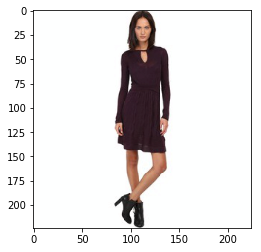

In [18]:
plt.imshow(np.clip(denorm(test_arr).transpose(1,2,0),0,1))

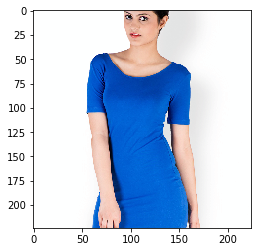

In [19]:
test_img2 = cv2.imread(PATH + "test/1.jpg")
test_arr2 = preprocess(test_img2)
plt.imshow(np.clip(denorm(test_arr2).transpose(1,2,0),0,1))

###  fastai preprocessing

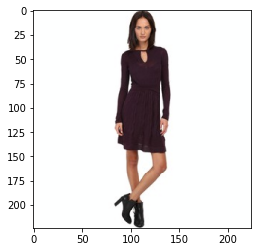

In [20]:
plt.imshow(np.clip(denorm(test_img_numpy[0]).transpose(1,2,0),0,1))

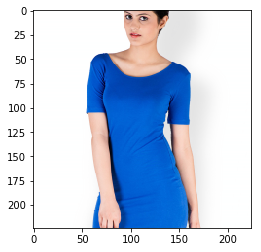

In [21]:
plt.imshow(np.clip(denorm(test_img_numpy[6]).transpose(1,2,0),0,1))

In [22]:
test_arr.dtype

dtype('float32')

In [23]:
test_arr.shape

(3, 224, 224)

In [24]:
np.exp(rep.run(np.expand_dims(test_arr,0)))

array([[[0.00089587, 0.00027989, 0.1490948 , 0.8497294 ]]], dtype=float32)

predictions are close, but not exactly the same as the images are slightly different

In [25]:
# images are not identical

In [26]:
np.allclose(test_img_numpy[0], test_arr)

False

In [27]:
((test_img_numpy[0] == test_arr) == True).sum()

118880

## Extra: without the batchnorm fix

In [28]:
model_no_batchnorm_fix = onnx.load("sleeves_no_batchnorm_fix.proto")


In [29]:
onnx.checker.check_model(model_no_batchnorm_fix)

In [30]:
onnx.helper.printable_graph(model_no_batchnorm_fix.graph)


'graph torch-jit-export (\n  %1[FLOAT, 1x3x224x224]\n) initializers (\n  %2[FLOAT, 64x3x7x7]\n  %3[FLOAT, 64]\n  %4[FLOAT, 64]\n  %5[FLOAT, 64]\n  %6[FLOAT, 64]\n  %7[FLOAT, 64x64x3x3]\n  %8[FLOAT, 64]\n  %9[FLOAT, 64]\n  %10[FLOAT, 64]\n  %11[FLOAT, 64]\n  %12[FLOAT, 64x64x3x3]\n  %13[FLOAT, 64]\n  %14[FLOAT, 64]\n  %15[FLOAT, 64]\n  %16[FLOAT, 64]\n  %17[FLOAT, 64x64x3x3]\n  %18[FLOAT, 64]\n  %19[FLOAT, 64]\n  %20[FLOAT, 64]\n  %21[FLOAT, 64]\n  %22[FLOAT, 64x64x3x3]\n  %23[FLOAT, 64]\n  %24[FLOAT, 64]\n  %25[FLOAT, 64]\n  %26[FLOAT, 64]\n  %27[FLOAT, 64x64x3x3]\n  %28[FLOAT, 64]\n  %29[FLOAT, 64]\n  %30[FLOAT, 64]\n  %31[FLOAT, 64]\n  %32[FLOAT, 64x64x3x3]\n  %33[FLOAT, 64]\n  %34[FLOAT, 64]\n  %35[FLOAT, 64]\n  %36[FLOAT, 64]\n  %37[FLOAT, 128x64x3x3]\n  %38[FLOAT, 128]\n  %39[FLOAT, 128]\n  %40[FLOAT, 128]\n  %41[FLOAT, 128]\n  %42[FLOAT, 128x128x3x3]\n  %43[FLOAT, 128]\n  %44[FLOAT, 128]\n  %45[FLOAT, 128]\n  %46[FLOAT, 128]\n  %47[FLOAT, 128x64x1x1]\n  %48[FLOAT, 128]\n  %49[FLO

rep is the caffe2 object, calling run with a numpy array will predict on that array

In [31]:
rep_no_batchnorm_fix = backend.prepare(model_no_batchnorm_fix)


In [32]:
outputs_no_batchnorm_fix = rep_no_batchnorm_fix.run(np.random.randn(1, 3, 224, 224).astype(np.float32))


Original python traceback for operator 126 in network `torch-jit-export_predict` in exception above (most recent call last):


RuntimeError: [enforce fail at spatial_batch_norm_op.cc:27] X.ndim() >= 3 && X.ndim() <= 5.  Error from operator: 
input: "391" input: "182" input: "183" input: "184" input: "185" output: "393" name: "" type: "SpatialBN" arg { name: "is_test" i: 1 } arg { name: "epsilon" f: 1e-05 } arg { name: "momentum" f: 0.9 } device_option { device_type: 0 cuda_gpu_id: 0 }

In [ ]:
outputs_no_batchnorm_fix